In [1]:
import torch
from models.model_utils import npdat2Tensor
def fetch_data(data_paths, batchsize, shuffle=True):
    print("setting up data")

    train_loaders = []
    for path in data_paths:
        npz_PropS = np.load(path)
        inputdata = torch.stack((npdat2Tensor(npz_PropS['Ucx']),
                                 npdat2Tensor(npz_PropS['Ucy']),
                                 npdat2Tensor(npz_PropS['Utc']),
                                 npdat2Tensor(npz_PropS['vel'])), dim=1)
        outputdata = torch.stack((npdat2Tensor(npz_PropS['Ufx']),
                                  npdat2Tensor(npz_PropS['Ufy']),
                                  npdat2Tensor(npz_PropS['Utf'])), dim=1)
        data_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(inputdata, outputdata),
                                                  batch_size=batchsize, shuffle=shuffle, num_workers=1)
        train_loaders.append(data_loader)

    return train_loaders

In [2]:
from models.model_utils import load_model
from models.unet import UNet
from models.tiramisu import FCDenseNet
import matplotlib.pyplot as plt
import numpy as np

#models
model_unet = UNet().double()
load_model("../results/run_1/saved_model_unet9.pt", model_unet)
# model_tir = FCDenseNet().double()
# load_model("../results/run_1/saved_model_tiramisu4.pt", model_tir)

#data
data_paths = data_paths = [
        '../data/train_data_fig9_128.npz',
        # '../data/train_data_waveguide_128.npz',
        # '../data/train_data_inclusion_128.npz',
        #'../data/train_data_bp_m_128.npz',
        #'../data/traindata_name14.npz'
]
train_loaders = fetch_data(data_paths, batchsize=1, shuffle=False)

setting up data


In [3]:
#getting one specific image
for train_loader in train_loaders:
        for i, data in enumerate(train_loader):
            if i == 5: #
                inputs, labels = data[0], data[1]
                outputs_unet = model_unet(inputs)
                #output_tiramisu = model_tir(inputs)
                break

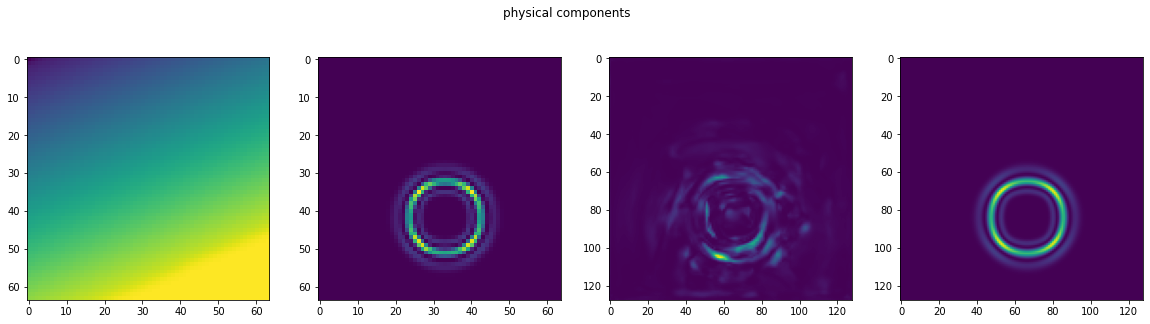

In [4]:
# compare physical components for single image
# plt.imshow(inputs[0][0])
# plt.show()
from generate_data.WaveUtil import WaveSol_from_EnergyComponent
from skimage.transform import resize
import generate_data.WaveUtil as wutil

l = [
    inputs[0], # wave energy component coarse solver (inputs),
    outputs_unet[0], # wave energy component enhanced through unet
    #output_tiramisu[0], # wave energy component enhanced through unet
    labels[0] # # wave energy component fine solver (label)
]
f, ax = plt.subplots(1,4)
f.suptitle("physical components")
f.set_figheight(5)
f.set_figwidth(20)
d = inputs[0][3,:,:].detach().numpy()

ax[0].imshow(d)
dx = 2.0/128.0

d2 = resize(d,(128,128)) # have it to same resolution as output img
for i, img in enumerate(l):
    if i == 1:
        d = d2
    a,b,c = img[0,:,:].detach().numpy(), img[1,:,:].detach().numpy(), img[2,:,:].detach().numpy()
    u, ut = WaveSol_from_EnergyComponent(a,b,c,d, dx, 10) # capital lambda dagger
    w = wutil.WaveEnergyField(u,ut,d,dx)
    ax[i+1].imshow(w)


# ax[1].set_title('coarse solver (input)')
# ax[2].set_title('fine solver (label)')
# ax[1].set_title('JNet(3,1) (output)')
# #ax[2].set_title('nn tiramisu (5,5), (5,5) (output)')
# ax[2].set_title('fine solver (label)')
# ax[3].imshow(d)
# ax[3].set_title('wavespeed')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'fine solver (label)')

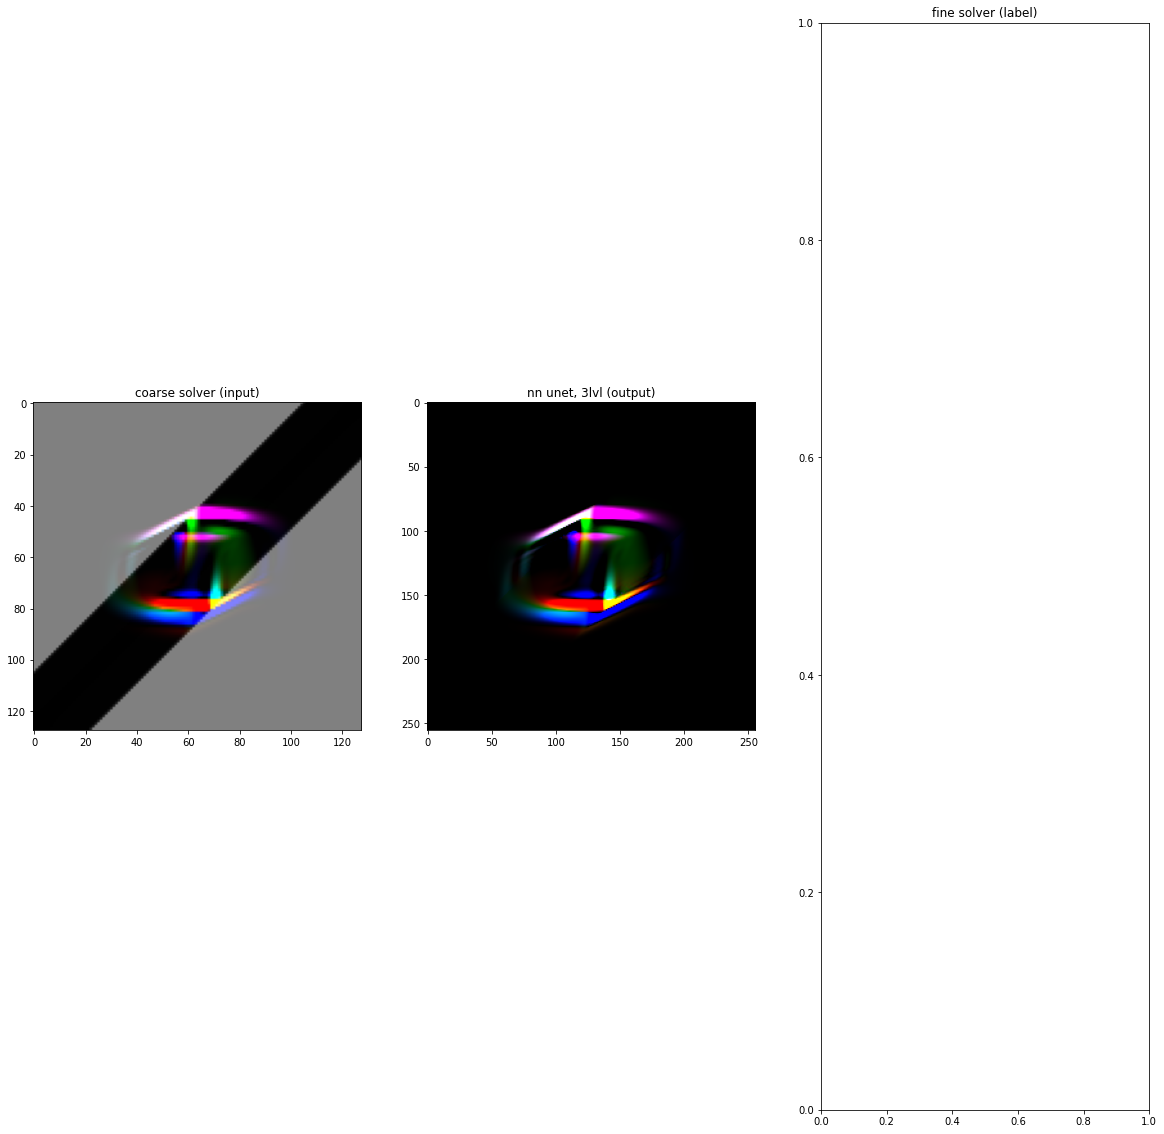

In [234]:
# compare energy components for single image

l = [
    inputs[0], # wave energy component coarse solver (inputs),
    #outputs_unet[0], # wave energy component enhanced through unet
    #output_tiramisu[0], # wave energy component enhanced through unet
    labels[0] # # wave energy component fine solver (label)
]
f, ax = plt.subplots(1,3)
f.set_figheight(20)
f.set_figwidth(20)

for i, img in enumerate(l):
    #print(img.shape)
    a = img[0]
    ax[i].imshow(img.permute(1,2,0).detach().numpy())

ax[0].set_title('coarse solver (input)')
ax[1].set_title('nn unet, 3lvl (output)')
#ax[2].set_title('nn tiramisu, 3lvl (output)')
ax[2].set_title('fine solver (label)')

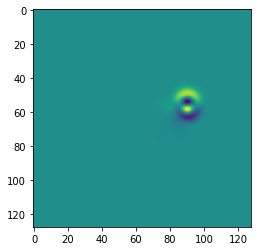